# Example: Training Binary Bernoulli Bandit Ticker Picker Agents
In this example, we create a group of `N` agents to assist us in selecting stocks for our portfolio $\mathcal{P}$. We will use the [$\epsilon$-Greedy Thompson Sampling algorithm](https://arxiv.org/abs/1707.02038) to solve a Multi-arm Binary Bandit problem. The choices of stocks that we can select from will be the bandits, and there are `K` of them in our choice set $\mathcal{C}$. We will feed daily return data to the group of `N` agents, who will learn which tickers return beyond a specified cutoff, such as the risk-free rate, in an online manner. 

Each agent will independently analyze daily Open High Low Close (OHLC) data sequences and develop a ranking of their belief that a particular ticker will return at least the risk-free rate in the next step. This ranking is based on the probability $p_{a}$, which represents the probability that the ticker will beat the risk-free rate. Each agent will express this probability as a belief distribution, represented by the parameters of a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution).

Once the analysis is complete, we will ask the agents to provide us with their `top-N` tickers. Subsequently, we could use these picks to populate our portfolio $\mathcal{P}$.

## Learning tasks and objectives
* __Prerequisites__: We'll load the daily Open High Low Close (OHLC) dataset and select tickers with complete data. We'll also compute the annualized daily return for each ticker in that dataset.
* __Task 1__: Develop a `world` function that agents will use to evaluate the possible actions and set up the ticker picker agents
    * `TODO`: Agents sample the `world.` If the ticker `XYZ` returns greater than or equal to the risk-free rate in the sample period, the agent receives a reward of `+1`. Otherwise, the agent gets a reward of `0`.
    * `TODO`: Initialize a collection of `N` ticker picker agents with an apriori belief that ticker `XYZ` is `good` or `bad`
* __Task 2__: In this task, we explore how the ticker picker agents learn which ticker symbols are better or worse bets.
    * `TODO`: Starting with a single ticker picker agent and a collection of `K` potential ticker symbols, we feed the agent daily (annualized) logarithmic return data and watch it evolve its belief system as new data is added.
* __Task 3__: Expand the single agent analysis to `N` agents, each exploring `K` potential ticker symbols.
    * `TODO`: After the agents complete their training, analyze their findings and have each agent compute its `top-N` ticker picks.  

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-2/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-2`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-2/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisites: Load and clean the historical dataset
We gathered daily open-high-low-close data for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. We'll use this data in the subsequent study, but we must load and clean it up first. In particular, in the `prerequisites` code block, we will:
* First, we'll load the data and remove tickers that do not have the maximum number of trading days. We'll store the cleaned data in the `dataset::Dict{String, DataFrame}` variable.
* Next, we'll get a list of all the tickers in the `dataset,` sort them alphabetically, and store them in the `all_tickers_array` variable.
* Finally, we'll compute the logarithmic return for tickers in the `dataset` using the `log_return_matrix(...)` function and store these values in the `all_firms_log_return_matrix` variable (assuming a `252`-day trading year)

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days::Int64` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Lastly, let's get a list of firms that we have in the cleaned-up `dataset::Dict{String,DataFrame}`, sort the list alphabetically, and save it in the `list_of_all_tickers` array.

In [11]:
list_of_all_tickers = keys(dataset) |> collect |> sort;

## __Task 1__: Initialize a world model and set up a ticker picker agent
Our first task is to construct models of the bandit model agent, and then we'll build a model of the world that this agent samples.
* First, we construct [a `MyEpsilonSamplingBanditModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.MyEpsilonSamplingBanditModel), using a [custom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.build-Tuple{Type{MyTickerPickerWorldModel},%20NamedTuple}). The [`MyEpsilonSamplingBanditModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.MyEpsilonSamplingBanditModel) holds data associated with the world.
* Next, we represent data associated with the world via a [`MyTickerPickerWorldModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.MyTickerPickerWorldModel). The [`MyTickerPickerWorldModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.MyTickerPickerWorldModel) is constructed using a [custom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.build-Tuple{Type{MyTickerPickerWorldModel},%20NamedTuple}).  

### TODO: Build a MyEpsilonSamplingBanditModel instance

First, specify the list of tickers we want to examine in the `my_tickers::Array{String,1}` array, and store the number of tickers in the `K::Int64` variable. The ticker-picker agents rank their preferences amongst the tickers in the  `my_tickers::Array{String,1}` array.

In [15]:
my_tickers = ["MRK", "JNJ", "MET", "NFLX", "AAPL", "AMD", "MU", "INTC", "MSFT", "SPY", "SPYD", "MMM",
    "UNH", "JPM", "OXY", "TSLA", "PEP", "LMT", "CMCSA", "ECL", "SRE", "BAC", "C", "WFC", "QQQ", "KR", "NOC", "GS", "NVDA"];
K = length(my_tickers);

Next, construct [a `MyEpsilonSamplingBanditModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.MyEpsilonSamplingBanditModel), which holds information about the [ϵ-greedy sampling approach](https://arxiv.org/abs/1707.02038).  
* The [`MyEpsilonSamplingBanditModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.MyEpsilonSamplingBanditModel) is constructed [using a custom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.build-Tuple{Type{MyEpsilonSamplingBanditModel},%20NamedTuple}) which takes two arguments:  The first is the type that we want to construct, i.e., [`MyEpsilonSamplingBanditModel`](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.MyEpsilonSamplingBanditModel) and the second is a [Julia `NamedTuple` instance](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) holding the number of arms `K::Int64`, initial values for the `α::Array{Int64,1}` and `β::Array{Int64,1}` arrays which hold the number of successes and failures for each arm, and `ϵ::Float64,` which controls the approximate fraction of `exploration` steps the algorithm takes; `exploration` steps are purely random. We save the sampling model instance to the `bandit_model::MyEpsilonSamplingBanditModel` variable:

In [17]:
bandit_model = build(MyEpsilonSamplingBanditModel, (
    K = K, # number bandit arms
    α = ones(K), # initialize to uniform values
    β = ones(K), # initialize to uniform values
    ϵ = 0.3, # fraction of random steps
));

### TODO: Setup a MyTickerPickerWorldModel instance
Now that we have set up the bandit model, we construct [a `MyTickerPickerWorldModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.MyTickerPickerWorldModel) which holds data about the world which we sample. The `world(...)` function takes problem data and returns a binary reward. First, we formulate the `world(...)` function, which takes the `start::Int64` index, an action $a\in\mathcal{A}$ value, and the `worldmodel::MyTickerPickerWorldModel.` The `world(...)` function returns a binary reward $r\in\left\{0,1\right\}$.

#### Summary of world function
`Unhide` the code block to see a reference implementation of the `world(...)` function. 
* We compare the wealth generated by investing `1 USD` in a fund that returns the risk-free rate for `buffersize::Int64` periods of $\Delta{t}$ duration (denoted as `W_risk_free`) versus `1 USD` in a `ticker` over the same period (denoted as `W_ticker`). If `W_ticker > W_risk_free`, the `world(...)` function returns `1`, i.e., success; otherwise, the `world(...)` function returns `0.`

In [19]:
function world(start::Int64, action::Int64, worldmodel::MyTickerPickerWorldModel)::Int64

    # get data from the world model -
    tickers = worldmodel.tickers;
    data = worldmodel.data;
    risk_free_rate = worldmodel.risk_free_rate;
    Δt = worldmodel.Δt;
    buffersize = worldmodel.buffersize;
    
    # initialize -
    result_flag = 0;

    # grab the ticker we are looking at?
    ticker_symbol = tickers[action];
    
    # compute the expected return over the horizon -
    price_df = data[ticker_symbol];
    time = range(start+1,(start+buffersize), step = 1) |> collect
    
    buffer = Array{Float64,1}();
    for t ∈ time
        P₁ = price_df[t-1, :volume_weighted_average_price]
        P₂ = price_df[t, :volume_weighted_average_price]
        R = (1/Δt)*log(P₂/P₁); # growth rate
        push!(buffer,R);
    end
    μ = sum(buffer);

    # if we invested 1 USD, in each how much would we have at the end of the horizon -
    W_risk_free = exp(buffersize*risk_free_rate*Δt);
    W_ticker = exp(μ*Δt);
    
    # Are we better or worse relative to the risk-free investment?
    (W_ticker > W_risk_free) ? result_flag = 1 : result_flag = 0;
    return result_flag;
end;

Next, you need to set the `buffersize::Int64` variable. This variable controls the number of trading periods of duration $\Delta{t}$ that we use to compute the return.
* __Note__: The reference implementation above uses overlapping evaluation periods, not discrete contiguous periods. A more realistic implementation would refactor the reference implementation to use non-overlapping periods.

In [21]:
buffersize = 5; # 1-trading week

Finally, we construct a [`MyTickerPickerWorldModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.MyTickerPickerWorldModel) using 
[a custom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.build-Tuple{Type{MyTickerPickerWorldModel},%20NamedTuple}). The [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.build-Tuple{Type{MyTickerPickerWorldModel},%20NamedTuple}) take two arguments: first, the [`MyTickerPickerWorldModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.MyTickerPickerWorldModel) and the second is a [Julia `NamedTuple` instance](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) holding data for the model:
* The [`MyTickerPickerWorldModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.MyTickerPickerWorldModel) requires the `my_tickers::Array{String,1}` array, the `data::Dict{String, DataFrame}` field holding the price data dictionary, the `world::Function`, the `risk_free_rate::Float64`, the duration of the time-step $\Delta{t}$, and the `buffersize::Int64` field. We store the world model in the `world_model::MyTickerPickerWorldModel` variable:

In [23]:
world_model = build(MyTickerPickerWorldModel, (
    tickers = my_tickers,
    data = dataset,
    world = world,
    risk_free_rate = 0.047,
    Δt = (1.0/252.0),
    buffersize = buffersize,
));

## __Task 2__: Run a single ticker-picker agent and explore its preferences
In this task, we use the world and bandit models to learn ticker preferences for a single agent using [the `sample(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.sample-Tuple{MyEpsilonSamplingBanditModel,%20MyTickerPickerWorldModel}). 
* The [`sample(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.sample-Tuple{MyEpsilonSamplingBanditModel,%20MyTickerPickerWorldModel}) takes a [`bandit_model::MyEpsilonSamplingBanditModel`](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.MyEpsilonSamplingBanditModel)
and a [`world_model::MyTickerPickerWorldModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.MyTickerPickerWorldModel)
along with the `horizon::Int64` parameter, i.e., how many iterations we want the search to run for,  and returns a dictionary holding the [`Beta` distributions](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Beta) for each arm (ticker) at each time point (keys) in the `time_sample_results_dict_eps` variable.
* _How do we set the `horizon` argument_? The `horizon::Int64` argument controls the number of consecutive time windows of length `buffersize::Int64` we use to train the bandit. Let's use all the available data, which is `maximum_number_trading_days - buffersize` values in this case. We subtract the `buffersize` so we don't run off the end of the data array for a ticker.

In [25]:
time_sample_results_dict_eps = VLQuantitativeFinancePackage.sample(bandit_model, world_model; 
    horizon = (maximum_number_trading_days - buffersize));

### TODO: Visualize the ticker-picker agent preferences
To visualize how the belief, i.e., preference of the ticker-picker agent, evolves as the agent encounters more data, first, specify a value for the `my_ticker_of_interest::String` variable, where `my_ticker_of_interest`$\in$`my_tickers.` We'll then find the index of your choice using [the Julia `findfirst(...)` method](https://docs.julialang.org/en/v1/base/arrays/#Base.findfirst-Tuple{Function,%20Any}), which searches over the `my_tickers` array and returns the first index of a match:

In [27]:
my_ticker_of_interest = "AAPL"; # specify your own ticker here!
index_of_ticker_to_plot = findfirst(x -> x==my_ticker_of_interest, my_tickers); 

#### Summary
To see how we visualized the belief distribution of the ticker-picker agent throughout the training for your chosen ticker, `unhide` the code block. 
* Initially, at the beginning of the training, the ticker-picker agent holds a uniform belief (represented by the yellow line) about the likelihood of your ticker outperforming a risk-free fund. This means that all possible beliefs about the probability of your ticker beating a risk-free fund are equally probable, indicating that the agent doesn't have a specific opinion yet. 
* However, as the ticker-picker agent gathers more data, its beliefs become more defined regarding the likelihood of your ticker performing better than the risk-free alternative. The progressively darker gray lines in the plot illustrate the evolution of these beliefs, with the final belief represented by the thick red line.

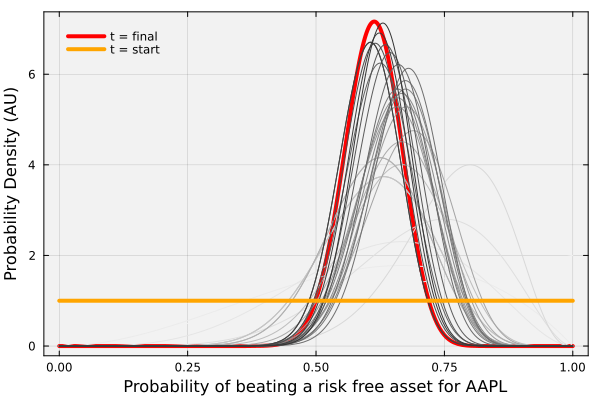

In [29]:
let
    
    # initialize -
    q = plot();
    number_of_trading_periods = length(time_sample_results_dict_eps);
    skip = 50;
    indexes_to_plot = range(2,number_of_trading_periods - 10,step=skip) |> collect;
    N = length(indexes_to_plot);
    C1 = colorant"gray95"
    C2 = colorant"gray20"
    gray_color_array = range(C1, C2, length=N);

    # initial plot -
    d = time_sample_results_dict_eps[number_of_trading_periods][index_of_ticker_to_plot]
    plot(d, label="t = final", c=:red, lw=4, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topleft);
    for i ∈ eachindex(indexes_to_plot)
        α = i/N;
        t = indexes_to_plot[i];
        d = time_sample_results_dict_eps[t][index_of_ticker_to_plot]
        plot!(d, label="", c=gray_color_array[i], lw=1)
    end
    d = time_sample_results_dict_eps[1][index_of_ticker_to_plot]
    plot!(d, label="t = start", c=:orange, lw=4)
    xlabel!("Probability of beating a risk free asset for $(my_ticker_of_interest)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()
end

## __Task 3__: Run a collection of ticker-picker agents and examine their preferences
In this task, let's repeat the single-agent analysis with `N` agents by running the [`sample(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.sample-Tuple{MyEpsilonSamplingBanditModel,%20MyTickerPickerWorldModel}) inside a [`for-loop`](https://docs.julialang.org/en/v1/base/base/#for). We'll store the results at a particular `trading_day_index::Int64` in the `agent_specific_data::Array{Beta,2}(undef, K, number_of_agents)` array. 
* The `agent_specific_data` array holds the [`Beta` distributions](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Beta) for each agent at `trading_day_index::Int64` for each `ticker`$\in$`tickers.` The `ticker` is the row index, and the agent's [`Beta` distributions](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Beta) is the column index, e.g., index (1,4) holds the preference for ticker = 1 held by agent = 4 at time `trading_day_index::Int64.`
* In the code block below, we use [the Julia `foreach(...)` iteration pattern](https://docs.julialang.org/en/v1/base/collections/#Base.foreach) to populate the `agent_specific_data` array. We could have also used [a simple `for-loop`](https://docs.julialang.org/en/v1/base/base/#for), but the [`foreach(...)` iteration pattern](https://docs.julialang.org/en/v1/base/collections/#Base.foreach) is more compact.

In [31]:
number_of_agents = 1000; # how many agents do we want
trading_day_index = 1479; # what trading day are we interested in?
agent_specific_data = Array{Beta,2}(undef, K, number_of_agents);

for agent_index ∈ 1:number_of_agents
    
    # sample -
    time_sample_results_dict_eps = VLQuantitativeFinancePackage.sample(bandit_model, world_model; 
        horizon = (maximum_number_trading_days - buffersize));

    # populate the agent_specific_data array
    foreach(k-> agent_specific_data[k, agent_index] = time_sample_results_dict_eps[trading_day_index][k], 1:K)
end

### TODO: Compute the wisdom of the collective
Now that we have preferences for the `N` agents (encoded as `Beta` distributions for each ticker) let's develop a consensus belief in which tickers we might include in our portfolio $\mathcal{P}$. First, compute the agent-specific rank of each `ticker`$\in$`my_tickers,` where `rank = 1` is the best, and `rank = K` is the worst. We'll store these values in the `preference_rank_array::Array{Int,2}` array.

In [33]:
preference_rank_array = Array{Int,2}(undef, number_of_agents, K);
for agent ∈ 1:number_of_agents
        
    # ask an agent about their preference for ticker i -
    experience_distributions = agent_specific_data[:,agent]
    preference_vector = preference(experience_distributions, my_tickers) .|> x-> trunc(Int64,x) # trunc function is cool!

    # package
    foreach(i -> preference_rank_array[agent, i] = preference_vector[i], 1:K);
end
preference_rank_array

1000×29 Matrix{Int64}:
 12  13   4   6  17   5  27   7  19  …  16  20   9  28  24  25  10  29   1
 28  20   4   8   1  25  18  14  24     20  22   7  17   2  23  11  12  16
 10   4   2   7  23   1  11  19   8     20  17  22  12   3  21  14  24   6
 28  14  15   7   2   4  13   5   1     18  20  17  26   6  11  22  24   9
 15   6  27  10   3  15   7  21   8     10  24  14   1   2   4  20  23   9
 20  29   5  12   1  18  26   2   9  …  27  13  22  28  17   8  18  21   4
 11  18   5   2   7   8  19  13  20      6  22  16  20  15  12   3   9   1
 23  21   5   4  24  27  19   9   1     10  25  11  21  21  25  15  17   2
 18  18  26  13  22   5   7  26   2     10  18   3  15   1  11   9  26   6
 28  22  25  10   4   7   3  23   5     19  17  24   6   2   9   8  25  17
  9  26  14   3  20  27  11  23   1  …   7   8  28  23  16  18  21  23  16
  2  23  13  12   1  20  10   7  17     10   5  22  26  14   4  19  18  24
  9  29  27   3   6  20   5   7   2     26  11  18   1   8  18  16   4  14
  

#### Compute the frequency dictionary
Let's count the times a `ticker` is ranked in the `top 10` across the `N` agents and then normalize by the number of agents, i.e., compute the frequency of being ranked in the `top 10`. We'll store this value in the `frequency_dictionary::Dict{String, Float64},` where the `ticker::String` is the key, and the frequency is the value.
* `Hypothesis`: Those `tickers` with high rank are likelier to beat an alternative risk-free investment, while low rank `tickers` do not outperform a risk-free alternative investment. 

In [35]:
frequency_dictionary = Dict{String,Float64}();
for i ∈ eachindex(my_tickers)
    
    # compute the frequency -
    freq = findall(x-> x ≤ 10, preference_rank_array[:,i]) |> x-> length(x) |> x-> x/number_of_agents
    
    # get the ticker -
    ticker = my_tickers[i];
    frequency_dictionary[ticker] = freq;
end

Describe the table

LoadError: UndefVarError: `rank` not defined

In [66]:
let
    
    # sort my tickers based on the alphabet -
    df = DataFrame();
    my_sorted_tickers = my_tickers |> sort;

    
    for i ∈ eachindex(my_sorted_tickers)
        ticker_value = my_sorted_tickers[i];
        j = findfirst(x -> x==ticker_value, my_tickers);
        median_rank = median(preference_rank_array[:,j]);
        
        freq_value = frequency_dictionary[ticker_value];
        row_df = (
            ticker = ticker_value,
            freq = freq_value,
            medianrank = median_rank
        );
        push!(df, row_df);
    end
    pretty_table(df);
end

┌────────┬─────────┬────────────┐
│ ticker │    freq │ medianrank │
│ String │ Float64 │    Float64 │
├────────┼─────────┼────────────┤
│   AAPL │   0.559 │        9.0 │
│    AMD │   0.479 │       11.0 │
│    BAC │   0.282 │       17.0 │
│      C │    0.26 │       16.0 │
│  CMCSA │   0.309 │       16.0 │
│    ECL │   0.439 │       12.0 │
│     GS │   0.258 │       17.0 │
│   INTC │    0.38 │       14.0 │
│    JNJ │   0.193 │       18.0 │
│    JPM │   0.268 │       16.0 │
│     KR │   0.265 │       17.0 │
│    LMT │   0.212 │       18.0 │
│    MET │    0.35 │       15.0 │
│    MMM │   0.184 │       18.0 │
│    MRK │   0.384 │       14.0 │
│   MSFT │   0.615 │        7.0 │
│     MU │   0.215 │       18.0 │
│   NFLX │   0.359 │       14.0 │
│    NOC │   0.316 │       15.0 │
│   NVDA │   0.482 │       11.0 │
│    OXY │   0.186 │       20.0 │
│    PEP │   0.291 │       16.0 │
│    QQQ │   0.591 │        8.0 │
│    SPY │   0.542 │        9.0 │
│   SPYD │   0.341 │       14.0 │
│    SRE │   0

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.